In [1]:
# Neural Network
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, ReLU
from tensorflow.keras.optimizers import Adam
# Environment


import gym
# Further support
import numpy as np
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
%load_ext tensorboard


Init Plugin
Init Graph Optimizer
Init Kernel


# Trajectory Storage 2.0
Numpy Version with full-batch return of epoch 


In [2]:
def discounted_reward_sum(rewards, gamma = 0.99):
        '''
        weighs all rewards in a way such that immediate rewards have a stronger impact than possible future rewards.

        Args:
        rewards(list): list of all rewards collected by the agent in episode t (?)
        gamma(float): Hyperparameter determining how much future rewards should be weighed in
        '''
        # To select the next reward
        i = 0
        discounted_rewards = []

        # Iterates through every reward and appends a discounted version to the output
        for r in rewards:
            disc = 0
            for t in rewards[i:-1]:
                discount_t = gamma ** t
                disc += t * discount_t
            i += 1
            discounted_rewards.append(disc)

        # returns list of discounted rewards.
        return sum(discounted_rewards)   

In [3]:
class Storage:

    def __init__(self, observation_dimension, size):
        self.observations = np.zeros((size, observation_dimension), dtype=np.float32)
        self.actions = np.zeros(size, dtype=np.int32)
        self.rewards = np.zeros(size, dtype=np.float32)
        self.episode_return = np.zeros(size, dtype=np.float32)
        self.baseline_estimates = np.zeros(size, dtype=np.float32)
        self.pointer_start, self.pointer_end= 0,0
        

    def store(self, observation, action, reward, baseline_estimate):
        self.observations[self.pointer_end] = observation
        self.actions[self.pointer_end] = action
        self.rewards[self.pointer_end] = reward
        self.baseline_estimates[self.pointer_end] = baseline_estimate
        self.pointer_end += 1

    def conclude_episode(self, last_value = 0):
        indexes = slice(self.pointer_start, self.pointer_end)
        rewards_total = np.append(self.rewards[indexes], last_value) # maybe weglassen?
        baseline_estimates_total = np.append(self.baseline_estimates[indexes], last_value) # den maybe auch?
        self.episode_return = discounted_reward_sum(self.rewards[indexes])
        self.pointer_start = self.pointer_end

    def get_episodes(self,actor):
        self.pointer_start, self.pointer_end = 0,0

        return self.observations, self.actions, self.rewards, np.mean(self.episode_return), self.baseline_estimates, actor.get_prob(self.actions, self.observations)
        

# Actor Model


In [4]:
class Actor(Model):
    '''
    Neural network computing the actions the agent will take
    '''


    def __init__(self, actionspace, struct=[256,128,64]):
        '''
        Initialize layer architecture for Actor Network.

        Args:
        actionspace(): number of possible actions the agent can take
        struct(): Width of layers in the network - must be of length = 3 
        '''
        # Subclassing API
        super(Actor, self).__init__()
        self.actionspace = actionspace
        
        self.l = [
            # Three Dense Layers with random initial parameters having a standart deviation of 0.01
            Dense(struct[0], activation="relu", kernel_initializer=tf.random_normal_initializer
            (stddev=0.01)),
            Dense(struct[1], activation="relu", kernel_initializer=tf.random_normal_initializer
            (stddev=0.01)),
            Dense(struct[2], activation="relu", kernel_initializer=tf.random_normal_initializer
            (stddev=0.01)),
            
            # Output layer with softmax activation function applied to for neurons.
            # Outputs prpobability for each of our for actions 
            # (Do nothing, fire left orientation engine, fire main engine, fire right orientation engine)
            Dense(self.actionspace, activation="softmax", kernel_regularizer=tf.random_normal_initializer(stddev=0.01))
        ]


    @tf.function        
    def call(self, x):
        '''
        Iterates input x through network to create softmax ouutput.

        Args:
        x(): Network input. Pixel values representing the current state of the agent
        '''
        for l in self.l:
            x = l(x)
        return x


    #@tf.function

    ## logits nur an stelle action zurück
    @tf.function
    def sample_action(self,observation):
        '''
        Calls the actor network with state of the agent and returns the network object + the samnpled action

        Args:
        observation(): Representation of actors state. Same as x in the call function. 
        '''
        # Output of softmax function

        logits = self(observation)

        # Sample action from the Softmax output of the network
        action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
        return logits, action


    #@tf.function
    def get_prob(self,actions, states):

        logits = self.call(states)
        logits_flat = tf.squeeze(logits)


        index_first_dim = tf.range(len(logits_flat))
        index_2D = tf.stack([index_first_dim, actions], axis=1)

        new_probs = tf.gather_nd(logits_flat, index_2D)
        
        return new_probs
            

# Critic Model

In [5]:
class Critic(Model):
    '''
    Represents the value function of the network. 
    Input is a certain state and output a float value for that state.
    '''


    def __init__(self,struct):
        '''
        Initialize layer architecture for Actor Network.

        Args:
        struct(): Width of layers in the network - must be of length = 3 
        '''
        # Subclassing API
        super(Critic, self).__init__()
        self.l = [
            # Three Dense Layers with ReLu activation function
            # Random initial parameters having a standart deviation of 0.01
            
            Dense(struct[0], activation="relu", kernel_initializer=tf.random_normal_initializer
            (stddev=0.01)),
            Dense(struct[1], activation="relu", kernel_initializer=tf.random_normal_initializer
            (stddev=0.01)),
            Dense(struct[2], activation="relu", kernel_initializer=tf.random_normal_initializer
            (stddev=0.01)),

            # Output layer with Tanh activation function to get float output value ([-1;1])
            # Random initial parameters having a standart deviation of 0.01
            Dense(1, activation="tanh", kernel_regularizer=tf.random_normal_initializer(stddev=0.01))
        ]


    @tf.function 
    def call(self, x):
        '''
        Iterates input x through network to create tanh output between -1 and 1 
        giving input state x a value.

        Args:
        x(): Network input. Pixel values representing the current state of the agent.
        '''
        for l in self.l:
            x = l(x)
        return x

In [6]:
class Agent:
    '''

    Currently contains:
    - Collects data
    - Training process (iterator, updater, actor loss fun)
    - get advantage function
    - dicount rewards function
    - Get ratio function

  
    '''

    def __init__(self, env_name, render=False, steps_per_epoch=1000, epochs=100, train_iterations=10, actor_structure=[256,128,64], critic_structure=[256,128,64]):
        ''' 
        Initialize Parameters.
        
        Args:
        env_name(): String Name of the Environment Passed
        render(): Boolean determining if env should be rendered during training
        steps_per_epoch(): how many steps/frame the agent should take during each Epoch of training; Default=1000
        epochs(): How many epochs of training should the agent do; Default=100
        actor_structure(): Define the Structure of the NN, Default: [256,128,64] (Can only take List of len 3)
        critic_structure(): Define the Structure of the NN, Default: [256,128,64] (Can only take List of len 3)
        '''
        # create environemt
        self.env = gym.make(env_name)
        self.observation_dimensions = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.n

        # set Hyperparameters
        self.lr = 3e-4
        self.clip_ratio = 0.2
        self.c_1 = 0.5
        self.train_policy_iterations = train_iterations
        self.optimizer = Adam(self.lr)
        self.render = render
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.actor_struct = actor_structure
        self.critic_struct = critic_structure
        
        # create models and temporary storage
        self.actor = Actor(self.num_actions,self.actor_struct)
        self.critic = Critic(self.critic_struct)
        self.storage = Storage(self.observation_dimensions, size=steps_per_epoch)


    def collect_train_data(self, epoch):
        '''
        Agent takes steps in environment according to current policy. Information gets saved to update policy.
        -> Data collection

        Args: 
        epoch(): Epoch inherited from wrapper function 'run' to correctly show epoch in TQDM Notebook
        '''
        observation, episode_return, episode_length = self.env.reset(), 0, 0
        episodes_total = 0
        # Iteration of whole training process
        

        # Initialize values for return, length and episodes
        sum_return = 0
        sum_length = 0
        num_episodes = 0

        # Each timestep t of steps_per_epoch (in paper denoted as capital T)
        #  allows takes on action in a state and saves the information in storage object
        for t in tqdm_notebook(range(self.steps_per_epoch), desc = 'Epoch:' + str(epoch+1)):

            # Toggles displaying of environment
            if self.render:
                self.env.render()

            # Reshaping observation to fit as input for Actor network (policy)
            observation = observation.reshape(1,-1)
            
            # Obtain action and logits for this observation by our actor
            logits, action = self.actor.sample_action(observation)
            
            # Take action in environment and obtain the rewards for it
            # Variable done represents wether agent has finished 
            # The last variable would be diagnostic information, not needed for training
            observation_new, reward, done, _ = self.env.step(action[0].numpy())

            # Sum up rewards over this episode and count amount of frames
            episode_return += reward
            episode_length += 1

            # Get the Base-Estimate from the Critics network
            base_estimate = self.critic(observation)

            # Store Variables collected in this timestep t
            self.storage.store(observation, action, reward, base_estimate)
            # Save the new state of our agent
            observation = observation_new
            
            # Check if terminal state is reached in environment
            if done or (t == self.steps_per_epoch - 1):
                # Save information about episode
                self.storage.conclude_episode()
                # Refresh environment and reset return and length value
                num_episodes += 1
                sum_length += episode_length
                sum_return += episode_return
                observation, episode_return, episode_length = self.env.reset(), 0, 0

        return num_episodes, sum_length/num_episodes, sum_return/num_episodes
                


    def actor_loss_fun(self,probs_old, probs_new, rewards, b_estimates, clip_param):
        '''
        Computes loss for Actor Network output.

        Args:
        logits_old():
        logits_new():
        reward():
        b_estimates_new():
        clip_param():
        '''
        

        # ratio = self.get_ratio_episode(actions, logits_old, logits_new)
        ratio = self.get_ratio(probs_old,probs_new)

        ### FIND OUT WHICH: SINGLE OR MULTIPLE ELEMENTS ARE WANTED AND ADJUST EITHER IN GET_ADV OR THE UPPER TWO FUNCTIONS
        advantage = self.get_advantage(rewards, b_estimates)
        
        # Unclipped value
        l1 = ratio * advantage
        # Clipped ratio between values determined by Hyperparam and multiplied by advantage (see objective function)
    
        l2 = tf.clip_by_value(ratio, clip_value_min=1-clip_param, clip_value_max=1+clip_param) * advantage

        return l1, l2


    def train_step(self, observations, actions, optimizer, rewards_old, probs_old, baseline_estimates,returns, clip_param, c_1 = 1, c_2=0.01):
        '''
        Updates actor network parameters and returns the loss to evaluate performance.

        Args:
        model(object): Object of the actor model.
        input(list): contains floats describing the actors state.
        loss_function(function): Clipped objective function for PPO.
        optimizer(object): Optimizer used to train actor.
        train_logits():
        train_rewards():
        clip_param():
        c_1(): 
        c_2():
        '''
        # use tf.gradientTape to compute loss, then gradients and apply these to the model to modify the parameters
        with tf.GradientTape(persistent=True) as tape:

            # obtain the probs of actions at observed states for the new policy
            probs_new = self.actor.get_prob(actions, observations)

            # Compute & weigh entropy 
            #entropy = c_2 * np.mean(-(logits_new * train_logits))   # <----- DOESNT WORK YET Musste ich erstmal rausnehmen für den Rest vom Debugging
            # entropy = 0.01

            # Computes MSE between output of the critics network (value) the discounted sum of rewards
            #  which represents an estimate based on rewards collected during training
            # critic_loss = c_1 * tf.keras.losses.MeanSquaredError(b_estimates_new, self.discounted_reward(train_rewards)).numpy()            
            critic_loss = tf.reduce_mean((returns - self.critic(observations)) ** 2)
            #actor_loss = entropy * self.actor_loss_fun(actions, train_logits, logits_new, train_rewards, b_estimates_new, clip_param)
            l1,l2 = self.actor_loss_fun(probs_old, probs_new, rewards_old, baseline_estimates, clip_param)


            actor_loss = -tf.reduce_mean(tf.minimum(l1, l2))
     
        a_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
        c_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
    

        # Update parameters
        optimizer.apply_gradients(zip(a_gradients, self.actor.trainable_variables))
        optimizer.apply_gradients(zip(c_gradients, self.critic.trainable_variables))

        # del tape

        return actor_loss, critic_loss




    def get_advantage(self, rewards, b_estimates, gamma = 0.99):
        '''
        Computes Advantage for action in state.

        Args:
        rewards(float): Reward for action.
        gamma(float): Discount factor.
        b_estimates(float): Baseline Estimates.
        
        '''

        # Get discounted sum of rewards 
        disc_sum = self.discounted_reward(rewards, gamma)

        # Convert lists to np arrays and flatten
        disc_sum_np = np.array(disc_sum)
        b_estimates_np = np.array(b_estimates)
        b_estimates_np = b_estimates_np.flatten()

        # substract arrays to obtain advantages
        advantages = np.subtract(disc_sum_np, b_estimates_np)

        return advantages



    def discounted_reward(self, rewards, gamma = 0.99):
        '''
        weighs all rewards in a way such that immediate rewards have a stronger impact than possible future rewards.

        Args:
        rewards(list): list of all rewards collected by the agent in episode t (?)
        gamma(float): Hyperparameter determining how much future rewards should be weighed in
        '''
        # To select the next reward
        i = 0
        discounted_rewards = []

        # Iterates through every reward and appends a discounted version to the output
        for r in rewards:
            disc = 0
            for t in rewards[i:-1]:
                discount_t = gamma ** t
                disc += t * discount_t
            i += 1
            discounted_rewards.append(disc)

        # returns list of discounted rewards.
        return discounted_rewards   




    def get_ratio(self, probs_old, probs_new):
        '''
        Returns the ratio of the logarithmic probability given by the old policy and the  logarithmic probability given by the new policy for an action in a state

        Args:
        probs_old():
        probs_new():
        '''

        log_probs_old = tf.nn.log_softmax(probs_old)
        log_probs_new = tf.nn.log_softmax(probs_new)

        ratio = tf.divide(log_probs_new,log_probs_old)
        return ratio




    def run(self, export = False):
        '''
        Wrapper funtion that can directly be called to train the agent.

        Args:
        export(bool): whether the Scores during Training should be exported and saved as a plot
        '''
        mean_returns = []
        mean_lengths = []
        num_episodes_total = 0
        for epoch in tqdm_notebook(range(self.epochs), desc = 'Epochs'):
            
            num_episodes, mean_length, mean_return = self.collect_train_data((epoch))
            observations, actions, rewards, returns, baseline_estimates, probs = self.storage.get_episodes(self.actor)
            for i in range(self.train_policy_iterations):
                self.train_step(observations, actions, self.optimizer, rewards, probs, baseline_estimates,returns, self.clip_ratio)
            num_episodes_total += num_episodes
            mean_returns.append(mean_return)
            mean_lengths.append(mean_length)
            print(f'Mean Return: {mean_return}. Average Length of Episode: {mean_length}. Total Episodes Trained: {num_episodes_total}')
        
        # export the training progress return values as png graph 
        if export:
            plt.figure()
            plt.ylabel('Average score per epoch')
            plt.xlabel('epoch')
            plt.title(f'Model Structure: {self.actor_struct}, LR: {self.lr}, training iterations: {self.train_policy_iterations}')
            plt.plot(range(self.epochs), mean_returns)
            plt.savefig(f'Model Structure:{self.actor_struct}_LR:{self.lr}_training iterations:_{self.train_policy_iterations}_figure.png',facecolor='white', edgecolor='none')


        self.env.close()


    def test(self, length=100):
        '''
        Tests the agent on a number of episodes and return the average score.
        Args: 
        length(int): number of episodes to test the agent over
        export(bool): whether the 
        '''
        reward_sum = 0
        for i in tqdm_notebook(range(length), desc = 'Test Episodes'):
            done = False
            observation = self.env.reset()
            
            while not done:
                self.env.render()        
                observation = observation.reshape(1,-1)
                _ , action = self.actor.sample_action(observation)
                observation_new, reward, done, _ = self.env.step(action[0].numpy())
                reward_sum += reward
                observation = observation_new
        print(f'Average score over {length} episodes: {reward_sum/length}.')


  

In [7]:
# Reset all states generated by Keras
tf.keras.backend.clear_session()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-09 23:19:51.507919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-09 23:19:51.508038: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch:1:   0%|          | 0/1000 [00:00<?, ?it/s]

2022-04-09 23:19:51.670640: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-09 23:19:51.671686: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-09 23:19:51.671809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-09 23:19:51.749441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-09 23:19:55.806874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-09 23:19:55.863258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-09 23:19:55.908653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:11

Mean Return: -182.2084788400984. Average Length of Episode: 90.9090909090909. Total Episodes Trained: 11


Epoch:2:   0%|          | 0/1000 [00:00<?, ?it/s]

Mean Return: -140.75764720822954. Average Length of Episode: 83.33333333333333. Total Episodes Trained: 23


Test Episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Average score over 20 episodes: -183.44262295687705.


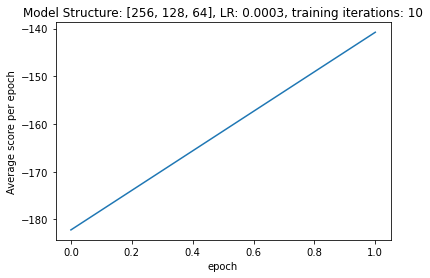

In [8]:

ppo_agent = Agent(env_name='LunarLander-v2', render=False,epochs=2)
ppo_agent.run(export=True)
ppo_agent.test(20)


# Meta Analysis for Hyperparameter Tuning 
Here we test out different Hyperparameters such as learning rate, model structure and training iterations

In [9]:
structures_models = np.array([[512,256,128],[256,128,64],[128,64,32]])
learninig_rates = np.array([1e-4,3e-4])
trainig_iterations = np.array([10,20,50])
